# Depth of Field Analysis

Adapted from Kenton's code

Look at variation with aperture, and plot in 3D

In [1]:
    import numpy as np
from skimage import io
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from celluloid import Camera
from IPython.display import HTML

In [2]:
PATH_TO_IMAGE =  '../data_store/2022-10-21 grating contd/f6_grating_stack_good/MMStack_Pos0.ome.tif/MMStack_Pos0.ome.tif'

In [3]:
A = [7, 8, 9, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 15, 15.5, 16, 17]
B = [7, 8, 9, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 17]
C = [9, 10, 11, 12, 13, 14, 15, 16, 16.5, 17, 17.5, 18, 18.5, 19, 20, 21]

In [4]:
def add_position_labels(axes, slices, positions):
    """
    Given 2x2 subplot axes intended to display each quartile
    image from a stack, apply the appropriate titles
    from a list of positions of stack images in mm. 
    """
    
    axes[0][0].set_title(f'{positions[0]} mm')
    axes[0][1].set_title(f'{positions[slices//4]} mm')
    axes[1][0].set_title(f'{positions[slices//2]} mm')
    axes[1][1].set_title(f'{positions[(slices*3)//4]} mm')
    
    return axes


def load_disp_img(path, positions, x_min=300, x_max=800, y_min=300, y_max=600, disp=False):
    """
    Load and crop stack, optionally display quartile images
    """
    
    im = io.imread(path)[:, x_min:x_max, y_min:y_max]
    
    if disp:
        f, axes = plt.subplots(2,2)
        slices = len(im)

        axes[0][0].imshow(im[0], cmap='gray')
        axes[0][1].imshow(im[slices//4], cmap='gray')
        axes[1][0].imshow(im[slices//2], cmap='gray')
        axes[1][1].imshow(im[(slices*3)//4], cmap='gray')

        axes = add_position_labels(axes, slices, positions)

        plt.tight_layout()
        plt.show()

    return im

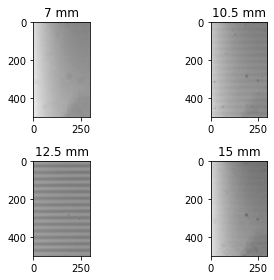

In [5]:
im = load_disp_img(PATH_TO_IMAGE, A, disp=True)

In [6]:
def line_prof_splash(im, positions):
    """
    Plot vertical line profiles through centre,
    for quartile images in stack
    """
    
    f, axes = plt.subplots(2,2,figsize=(15, 15))
    slices = len(im)
    centre = im.shape[2]//2
    
    axes[0][0].plot(im[0,:,centre])
    axes[0][1].plot(im[slices//4,:,centre])
    axes[1][0].plot(im[slices//2,:,centre])
    axes[1][1].plot(im[(slices*3)//4,:,centre])
    
    axes = add_position_labels(axes, slices, positions)

    plt.show()

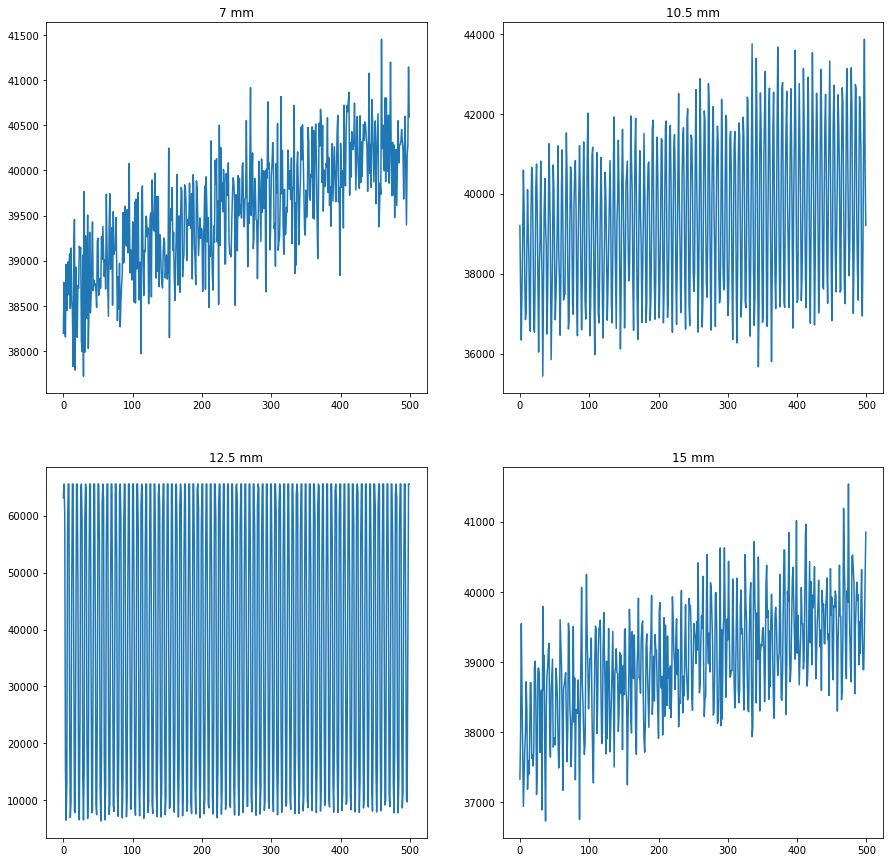

In [7]:
line_prof_splash(im, A)

In [8]:
def fourier(frame, plot=False):
    """
    Return Fourier transform array and frequency axes, optionally plot log(FFT) in 2D
    
    Adapted from:
    - https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/
    - https://stackoverflow.com/a/39201385
    
    TODO: understand how to adapt to real lengths
    """
    
    ft = np.fft.ifftshift(frame)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    freq_x = np.fft.fftfreq(ft.shape[0])
    freq_y = np.fft.fftfreq(ft.shape[1])
    
    if plot:
        plt.imshow(
            np.log10(np.abs(ft)),
            extent=(freq_x.min(),freq_x.max(),freq_y.min(),freq_y.max()),
            aspect=1
        )
        plt.colorbar()
        plt.xlabel('f_x (/pixel)')
        plt.ylabel('f_y (/pixel)')
        plt.show()
               
    return ft, (freq_x, freq_y)

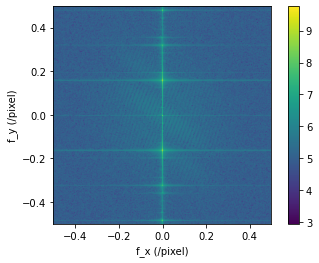

In [9]:
ft, freqs = fourier(im[len(im)//2], plot=True)

In [10]:
def fft_plot_centre_y(frame):
    ft, freqs = fourier(frame)
    plt.plot(np.fft.fftshift(freqs[0]), (np.abs(ft)[:,ft.shape[1]//2]))
    plt.xlabel('f_y (/pixel)')
    plt.show()

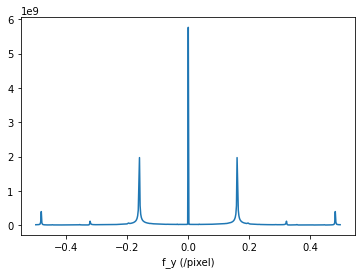

In [11]:
fft_plot_centre_y(im[len(im)//2])

In [12]:
def fft_plot_quartiles(im, positions):
    # TODO: are there better ways to represent this? or to quantify it?
    slices = len(im)
    qrts = [0, slices//4, slices//2, (slices*3)//4]
    
    ax = plt.figure(figsize=(30, 10)).add_subplot(projection='3d')

    for q in qrts:
        ft, freqs = fourier(im[q])
        ax.plot(np.fft.fftshift(freqs[0]), (np.abs(ft)[:,ft.shape[1]//2]), positions[q])
        
    ax.set_xlabel('f_y (/pixel)')
    ax.set_zlabel('distance (mm)')
    ax.view_init(azim=20, elev=20, vertical_axis='y')
    plt.show()

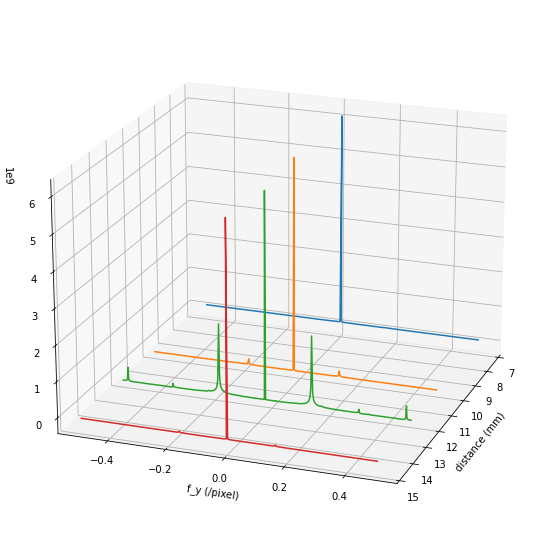

In [13]:
fft_plot_quartiles(im, A)

---

## Comparing apertures

In [14]:
def speed_run(path, positions):
    # quick and dirty comparison - run everything for each stack
    # this will vomit plots all over the notebook - be warned!
    im = load_disp_img(path, positions)
    line_prof_splash(im, positions)
    ft, freqs = fourier(im[len(im)//2], plot=True)
    fft_plot_centre_y(im[len(im)//2])
    fft_plot_quartiles(im, positions)

In [15]:
# speed_run('../data_store/2022-10-21 grating contd/f10 stack/MMStack_Pos0.ome.tif/MMStack_Pos0.ome.tif', B)

In [16]:
# speed_run('../data_store/2022-10-21 grating contd/f22 stack/MMStack_Pos0.ome.tif', B)

In [17]:
BASE_PATH = '../data_store/2022-10-21 grating contd/'
f6 = BASE_PATH + '/f6_grating_stack_good/MMStack_Pos0.ome.tif/MMStack_Pos0.ome.tif'
f10 = BASE_PATH + 'f10 stack/MMStack_Pos0.ome.tif/MMStack_Pos0.ome.tif'
f22 = BASE_PATH + '/f22 stack/MMStack_Pos0.ome.tif' # this one saved differently - annoying!

In [18]:
def fft_plot_quartiles_compare(paths, positions_lists, imgnames):  
    fig = plt.figure(figsize=(30, 10))
    num = len(paths)
    
    for i in range(num):
        ax = fig.add_subplot(1, num, i+1, projection='3d')
        
        im = load_disp_img(paths[i], positions_lists[i])
        slices = len(im)
        qrts = [0, slices//4, slices//2, (slices*3)//4]
        # qrts = range(slices)

        for q in qrts:
            ft, freqs = fourier(im[q])
            ax.plot(np.fft.fftshift(freqs[0]), (np.abs(ft)[:,ft.shape[1]//2]), positions_lists[i][q])

        ax.set_xlabel('f_y (/pixel)')
        ax.set_zlabel('distance (mm)')
        ax.set_title(imgnames[i])
        ax.view_init(azim=20, elev=20, vertical_axis='y')

    plt.tight_layout()
    plt.show()

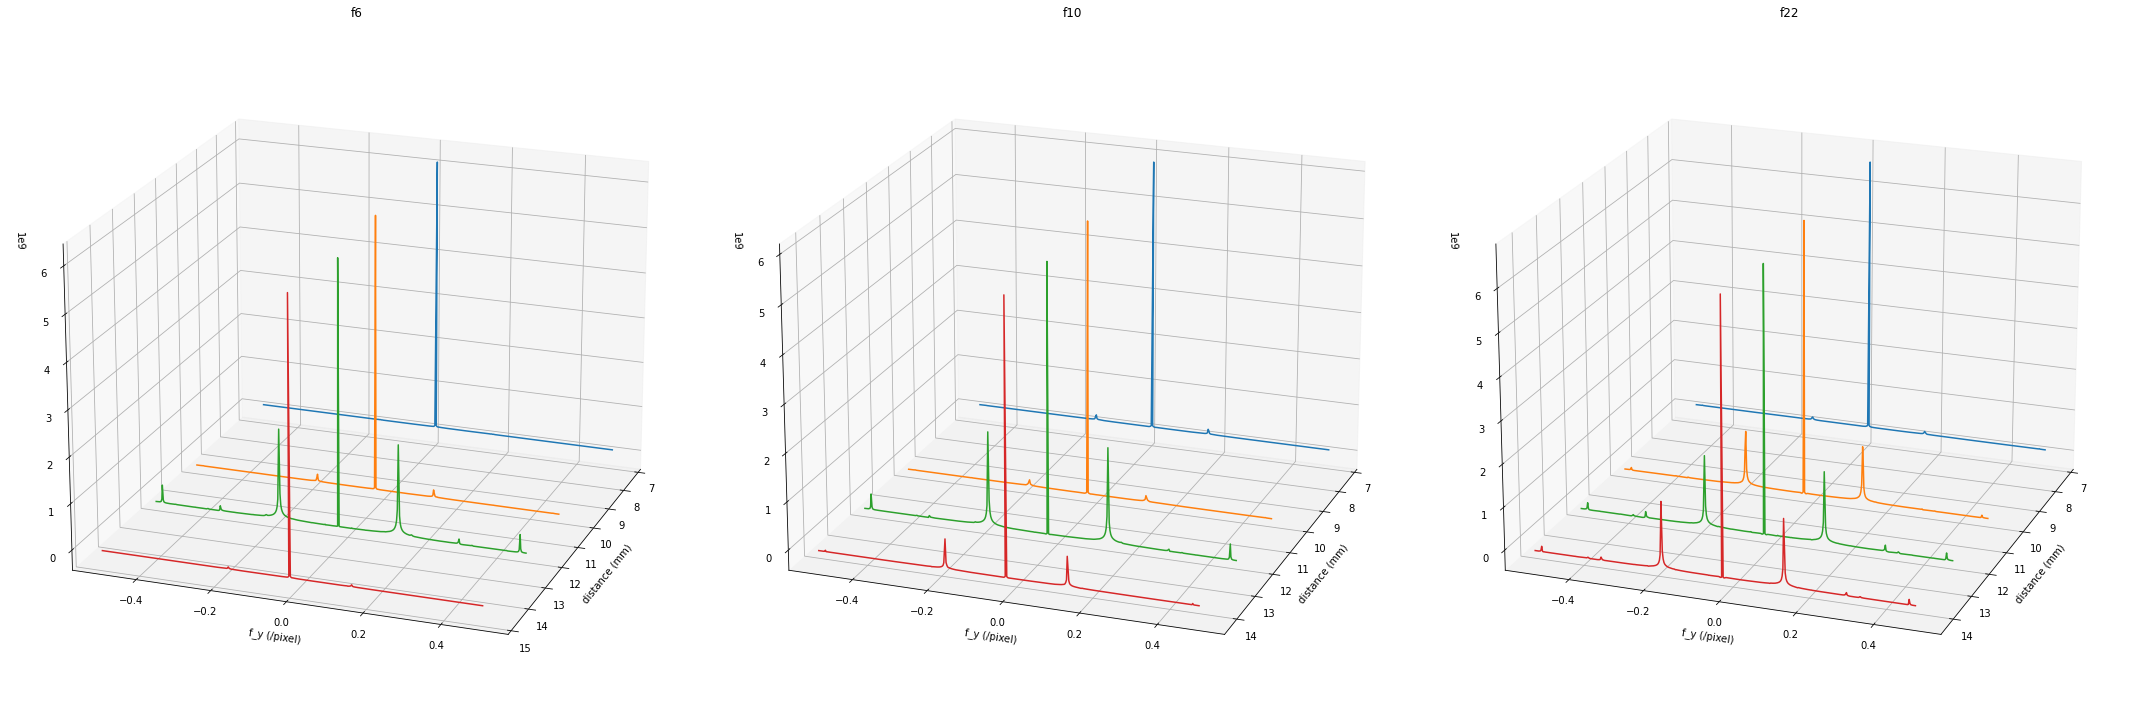

In [19]:
fft_plot_quartiles_compare([f6, f10, f22], [A, B, B], ['f6', 'f10', 'f22'])

In [20]:
# checking we also get sensible results for the different media
air = BASE_PATH + '/f6 stack air/MMStack_Pos0.ome.tif'
water = BASE_PATH + 'f6 stack water/MMStack_Pos0.ome.tif'

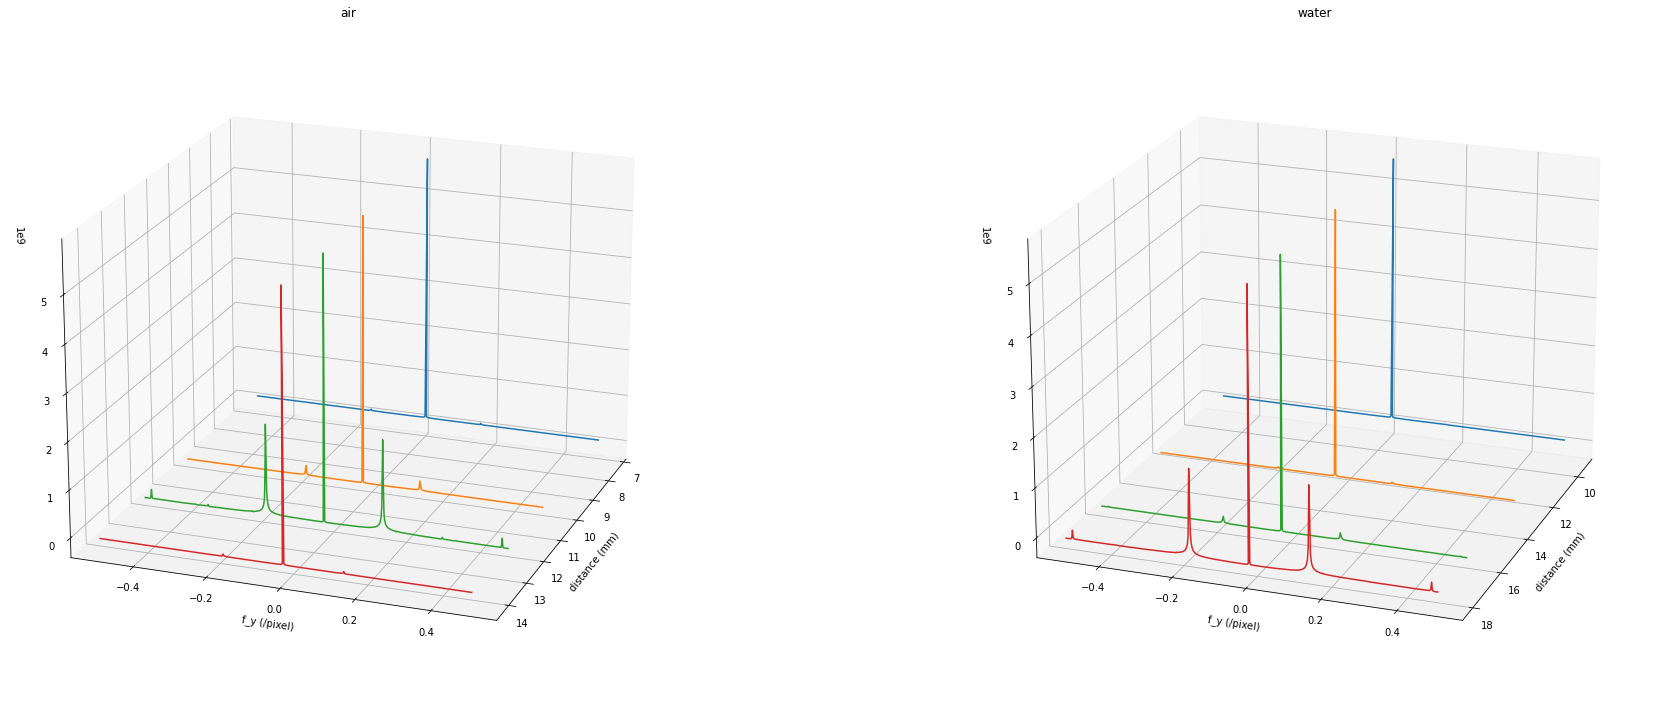

In [21]:
fft_plot_quartiles_compare([air, water], [B, C], ['air', 'water'])

---

Coarser grating data set (2022-10-27)

In [22]:
# BASE_PATH = '../data_store/2022-10-27/'
# f6 = BASE_PATH + '2022-10-27 f6 depth sweep (reordered).tif'
# f8 = BASE_PATH + '2022-10-27 f8 depth sweep (reordered).tif'

In [23]:
# D = [3, 4, 5, 6, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12.5, 13.5]

In [24]:
# fft_plot_quartiles_compare([f6, f8], [D, D[:-1]], ['f6', 'f8'])
# # i don't trust the positions of these images - f8 should be the same length!
# # just plotting to check that we see more harmonics with the coarser grating
# # need to figure out the positions before doing any depth of field analysis

---

Repeat of coarse grating data - with known positions this time!

In [25]:
BASE_PATH = '../data_store/2022-10-31 dof contd/aperture/'
f6 = BASE_PATH + '2022-10-31-f6 depth sweep wide range stack/MMStack_Pos0.ome.tif'
f10 = BASE_PATH + '2022-10-31-f10 depth sweep wide range stack/MMStack_Pos0.ome.tif'
f22 = BASE_PATH + '2022-10-31-f22 depth sweep wide range stack/MMStack_Pos0.ome.tif'

In [26]:
E = np.arange(25, -1, -1)

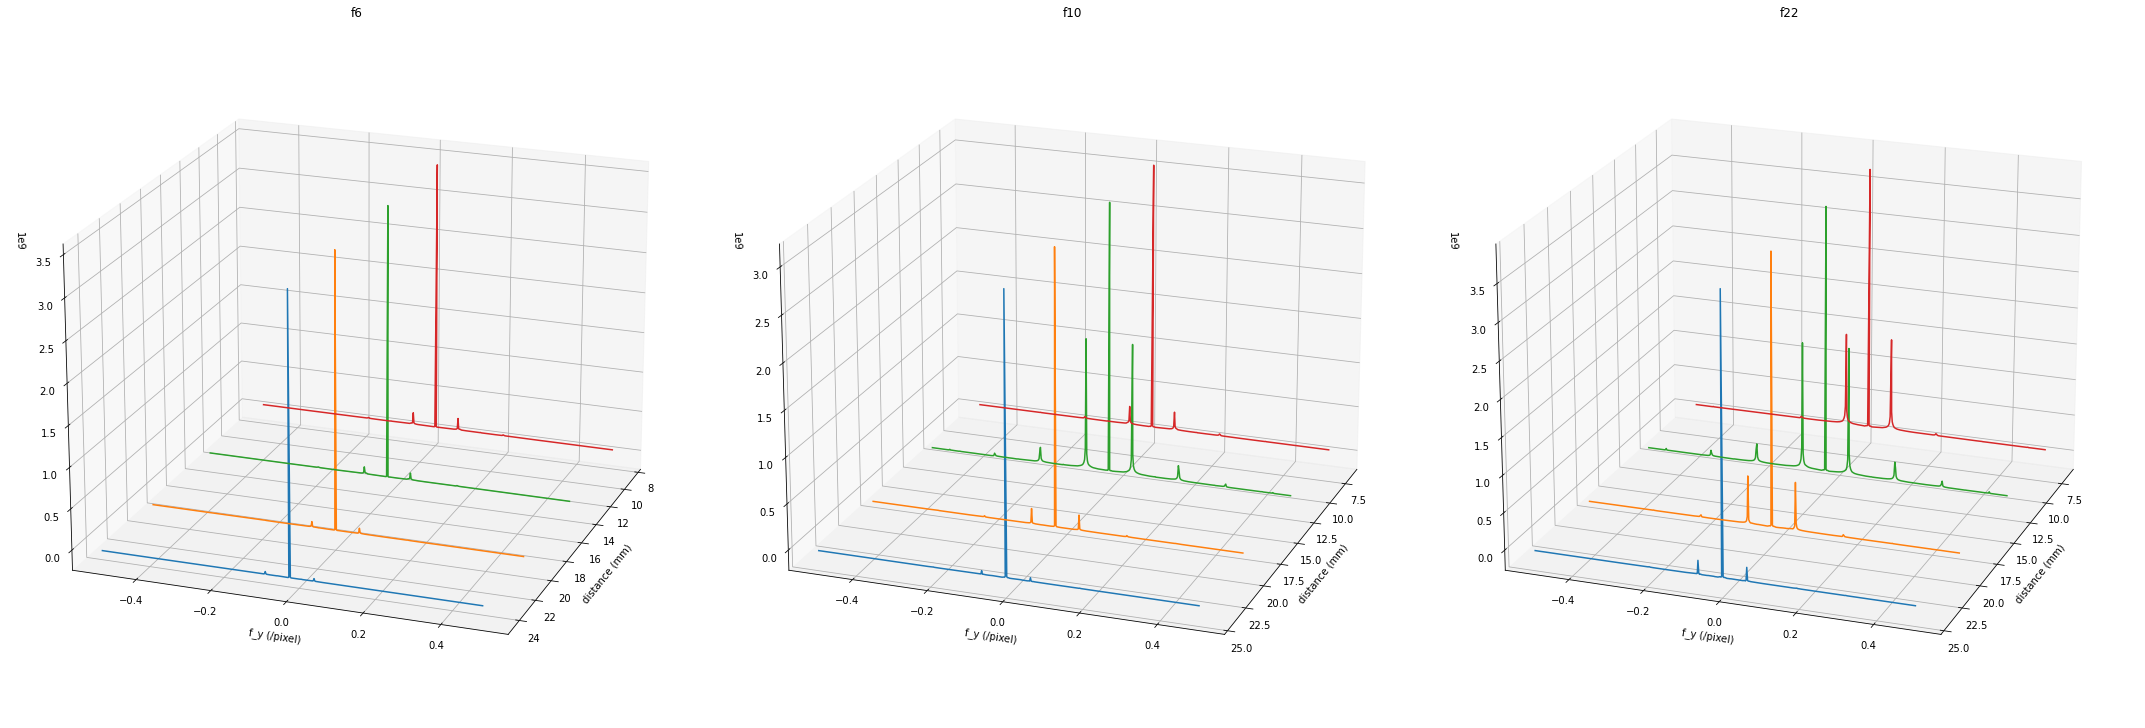

In [27]:
fft_plot_quartiles_compare([f6, f10, f22], [E[:-3], E, E], ['f6', 'f10', 'f22'])

## Peak finding

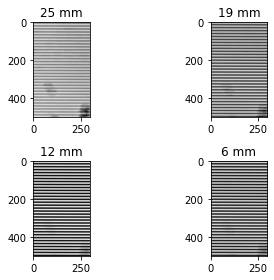

In [28]:
im = load_disp_img(f22, E, disp=True)

In [29]:
def fft_find_peaks(frame, thresh=0.02e9, disp=False):
    ft, freqs = fourier(frame)
    peak_indices, properties = find_peaks(np.abs(ft)[:,ft.shape[1]//2], height=thresh)
    
    if disp:
        plt.plot(np.fft.fftshift(freqs[0]), (np.abs(ft)[:,ft.shape[1]//2]))
        plt.plot(np.fft.fftshift(freqs[0])[peak_indices], properties['peak_heights'],'x')
        plt.xlabel('f_y (/pixel)')
        plt.show()
        
    return peak_indices, properties
    

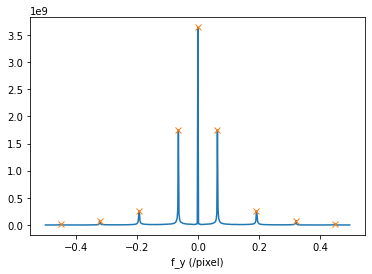

In [30]:
peaks, props = fft_find_peaks(im[len(im)//2], disp=True)

In [31]:
def fft_find_peaks_anim(im, positions, thresh=0.02e9):
    fig = plt.figure(figsize=(15, 10))
    plt.xlabel('f_y (/pixel)')
    camera = Camera(fig)
    
    for i in range(len(im)):
        ft, freqs = fourier(im[i])
        peak_indices, properties = find_peaks(np.abs(ft)[:,ft.shape[1]//2], height=thresh)
        line = plt.plot(np.fft.fftshift(freqs[0]), (np.abs(ft)[:,ft.shape[1]//2]))
        plt.plot(np.fft.fftshift(freqs[0])[peak_indices], properties['peak_heights'],'x')
        plt.legend(line, [f'{positions[i-1]} mm'])
        camera.snap()
    
    animation = camera.animate()
    return animation

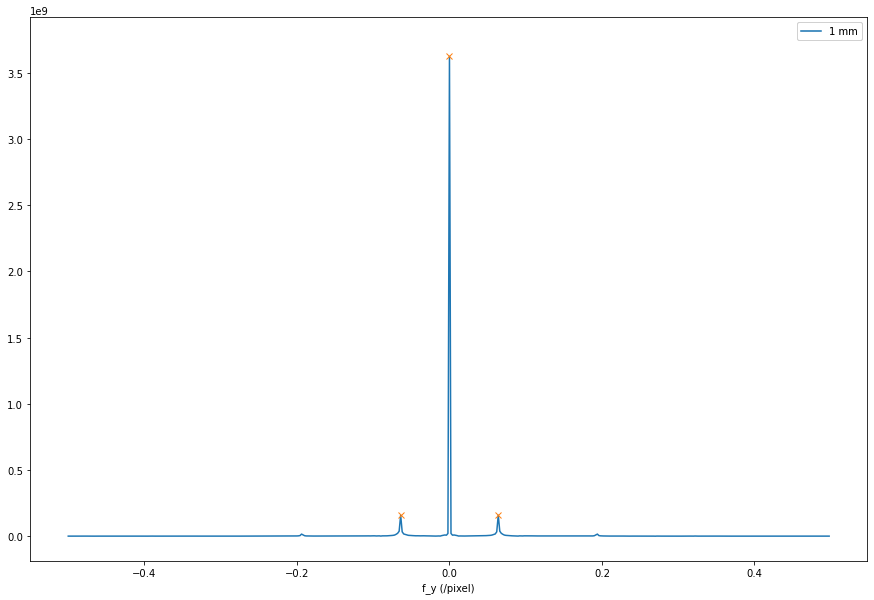

In [32]:
fft_find_peaks_anim(im, E).save('f22.mp4')

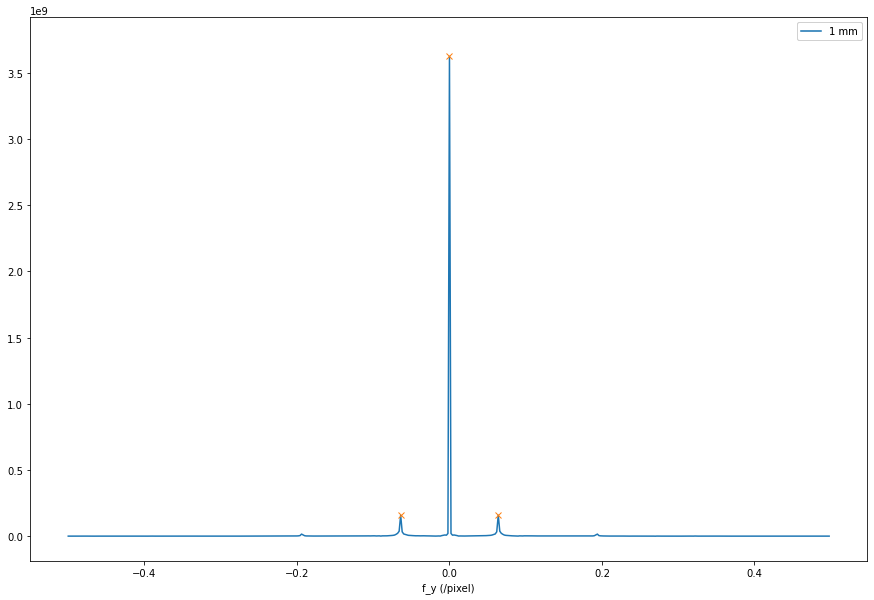

In [33]:
HTML(fft_find_peaks_anim(im, E).to_html5_video())

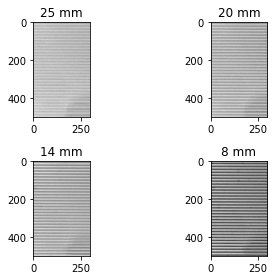

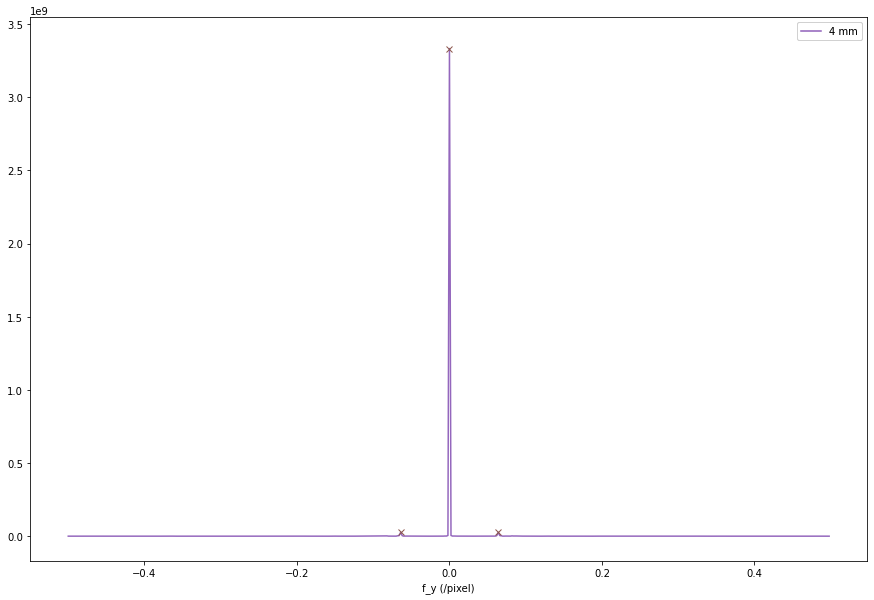

In [34]:
im = load_disp_img(f6, E[:-3], disp=True)
fft_find_peaks_anim(im, E[:-3]).save('f6.mp4')

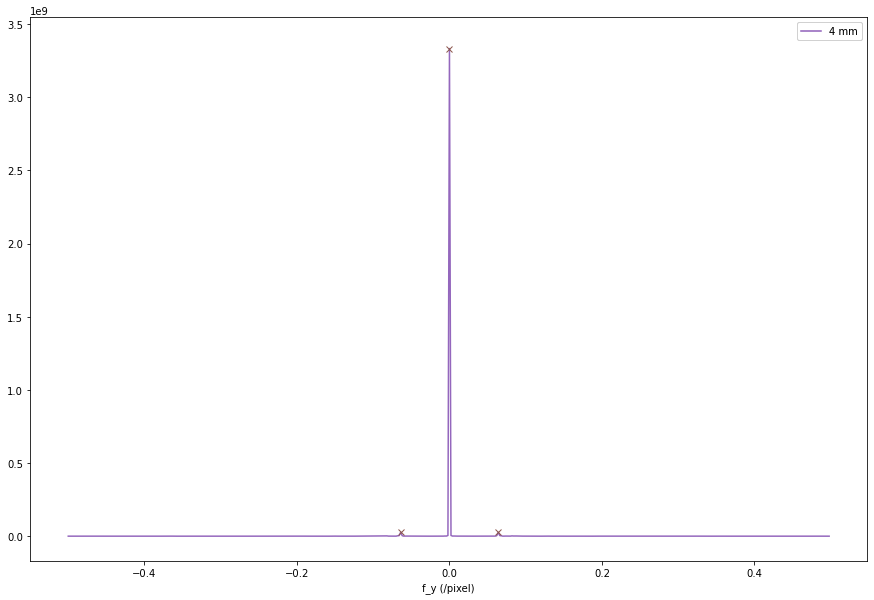

In [35]:
HTML(fft_find_peaks_anim(im, E[:-3]).to_html5_video())

## Colours

In [36]:
BASE_PATH = '../data_store/2022-10-31 dof contd/wavelength/'
red = BASE_PATH + '2022-10-31-f6 depth sweep red filter/MMStack_Pos0.ome.tif'
green = BASE_PATH + '2022-10-31-f6 depth sweep green filter/MMStack_Pos0.ome.tif'
blue = BASE_PATH + '2022-10-31-f6 depth sweep blue filter/MMStack_Pos0.ome.tif'

In [37]:
F = np.arange(20, 1, -1)

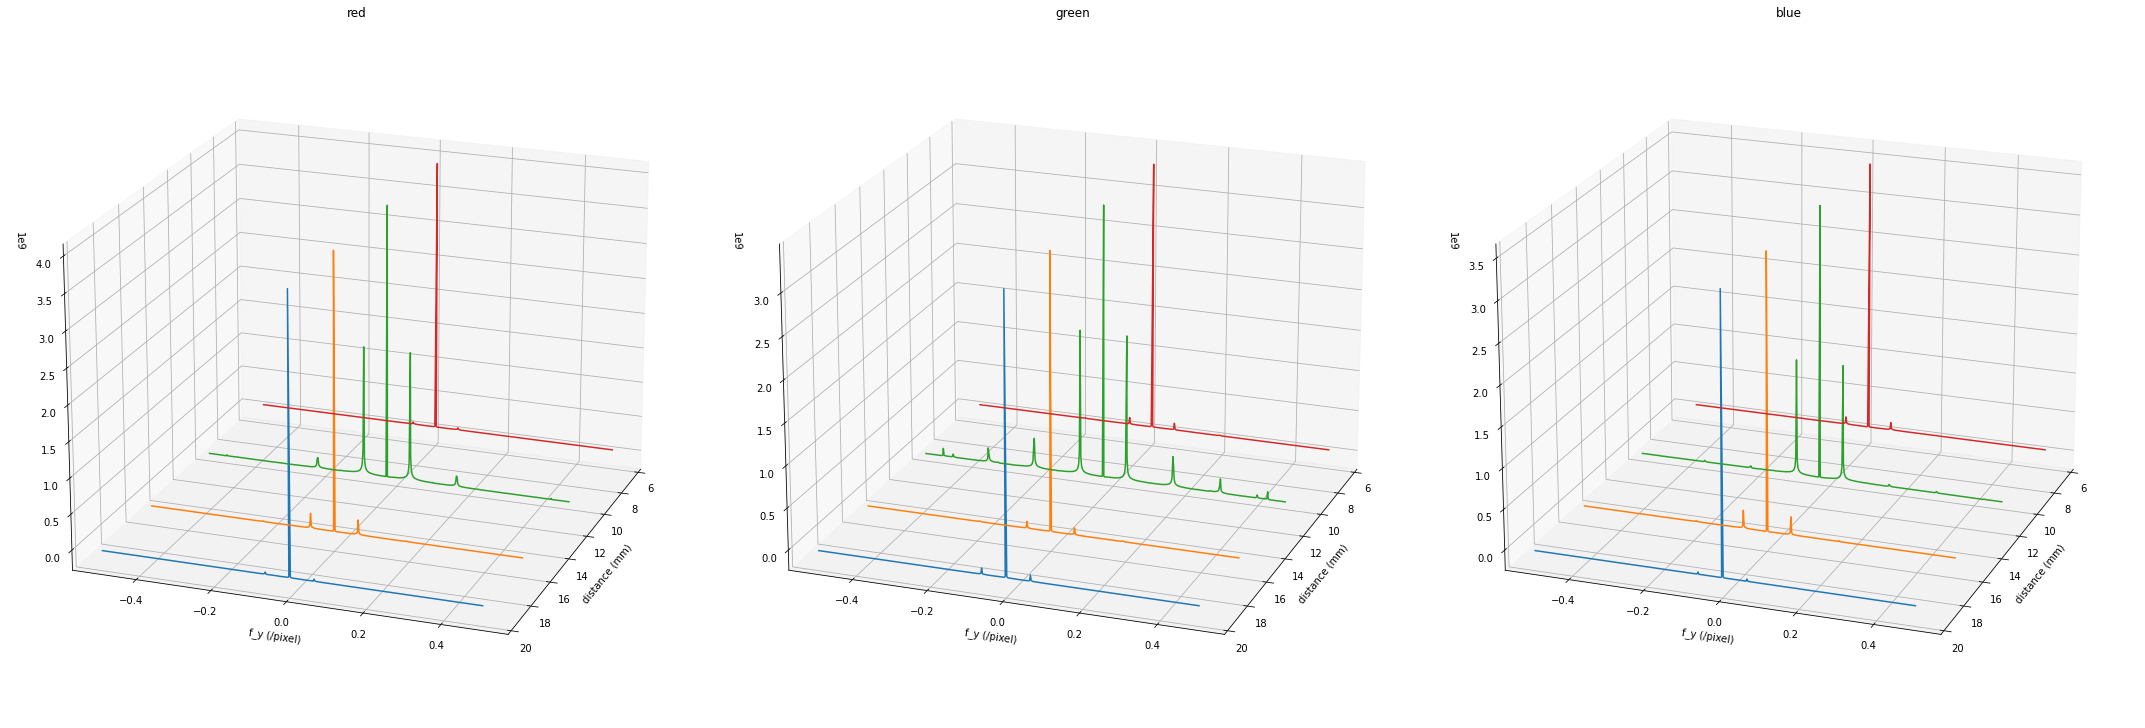

In [38]:
fft_plot_quartiles_compare([red, green, blue], [F, F, F], ['red', 'green', 'blue'])

## Doing something useful with peaks

In [39]:
def peak_distance_plots(paths, positions_lists, imgnames):
    fig = plt.figure(figsize=(30, 10))
    num = len(paths)

    for i in range(num):
        ax = fig.add_subplot(1, num, i+1)
        im = load_disp_img(paths[i], positions_lists[i])
        peaks_lists, properties_lists = map(list, zip(*[fft_find_peaks(im[i], thresh=0.05e9) for i in range(len(im))]))
        ax.plot(positions_lists[i], [max(peaks) for peaks in peaks_lists])
        ax.set_ylabel('distance between furthest peaks')
        ax.set_xlabel('depth (mm)')
        ax.set_title(imgnames[i])
        
    plt.tight_layout()
    plt.show()

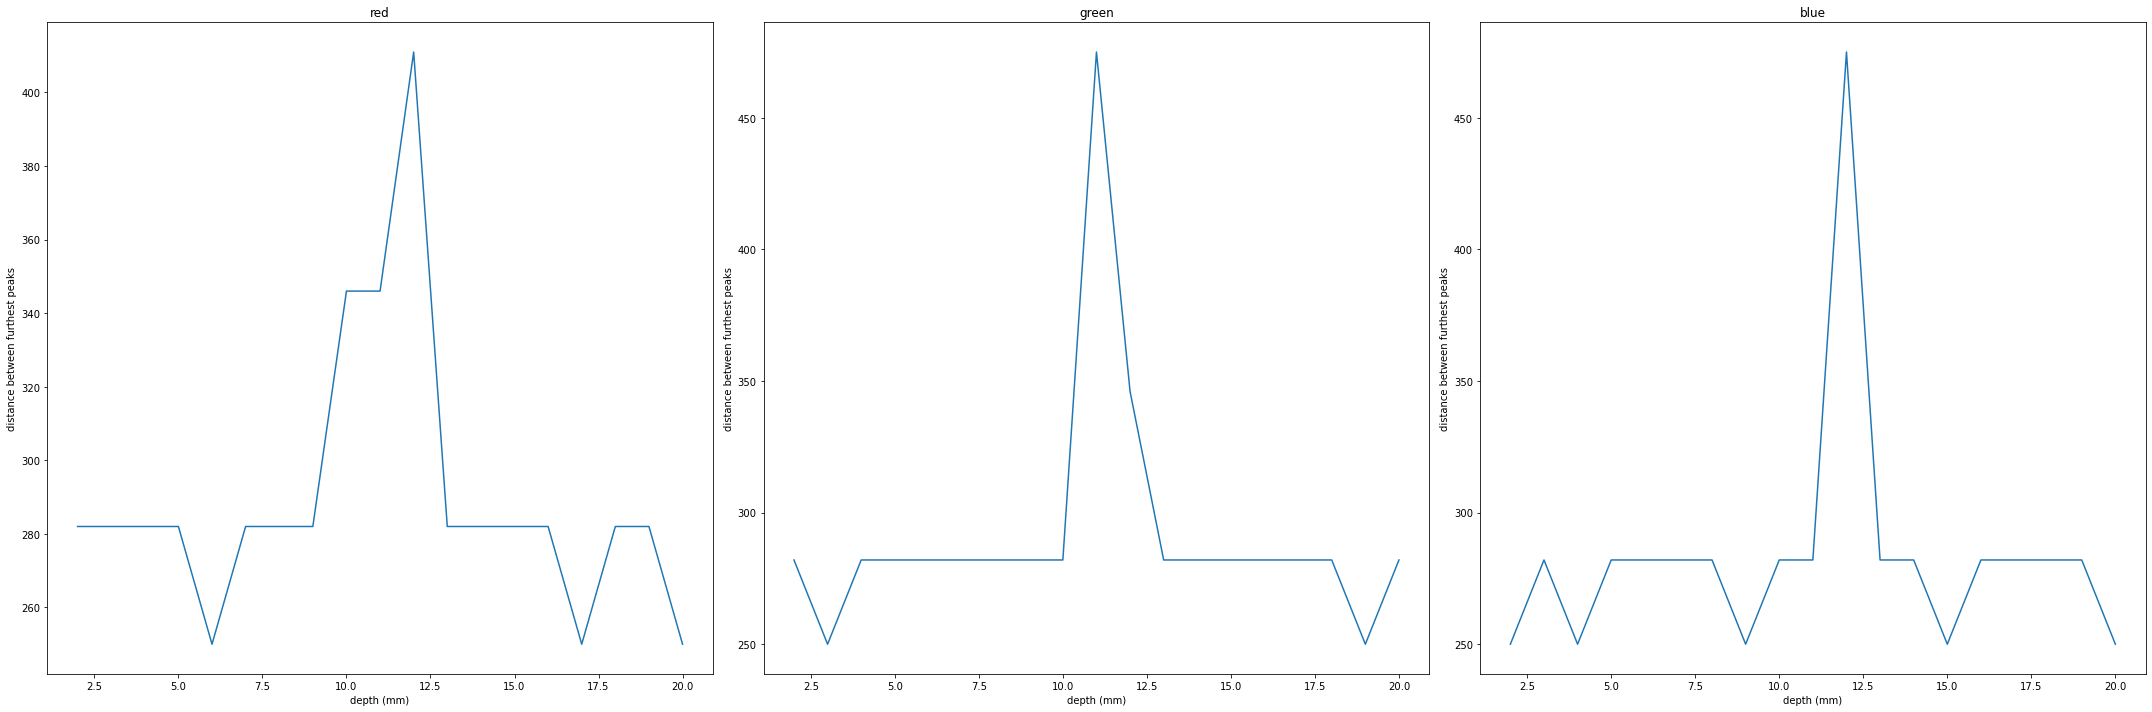

In [40]:
peak_distance_plots([red, green, blue], [F, F, F], ['red', 'green', 'blue'])

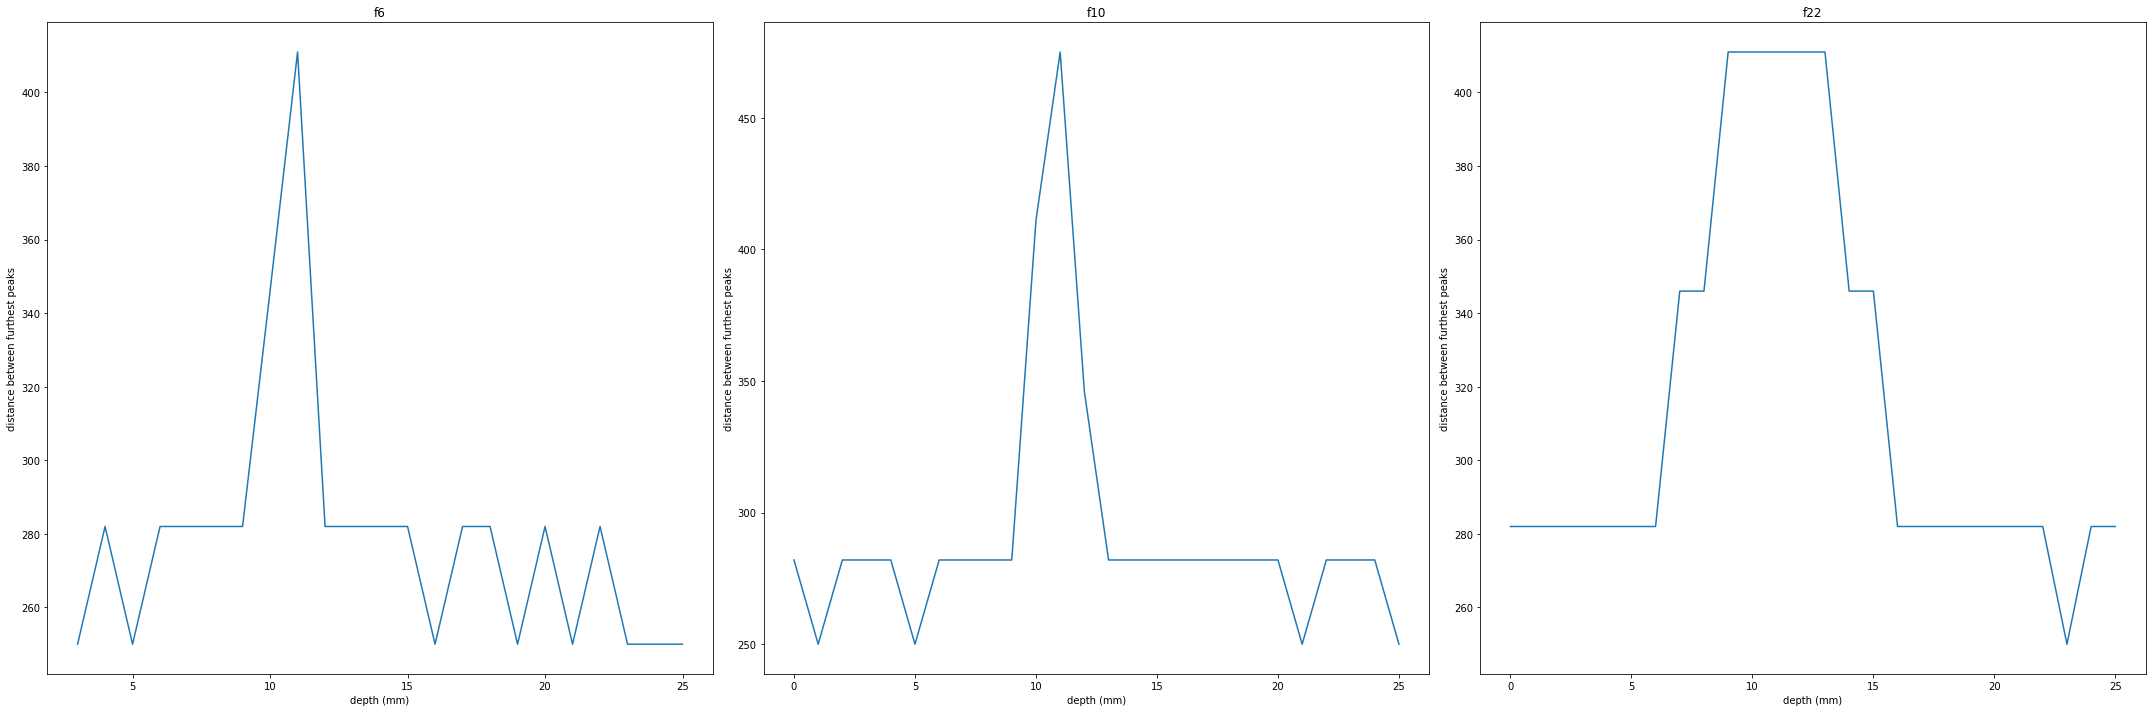

In [41]:
peak_distance_plots([f6, f10, f22], [E[:-3], E, E], ['f6', 'f10', 'f22'])